In [151]:
import numpy as np
import matplotlib.pyplot as plt
from generate_magnetic_field import get_mag_field
import torch.nn as nn
import torch

In [152]:
# genrate coordinate mesh 
x_data_points = 11
x_array = np.linspace(-1,1,x_data_points)
x_array
xv,yv,zv = np.meshgrid(x_array,x_array,x_array,indexing='ij')

In [153]:
# create BV mask 
xyv_mask    = ((xv==-1) + (xv==0) + (xv==1)) * ((yv==-1) + (yv==0) + (yv==1))
zv_mask     = (zv==-1) + (zv ==1) + (zv==0)
center_mask = (xv==0)*(yv==0)*(zv==0)
bv_mask     = (xyv_mask) * (zv_mask)* (~center_mask)

In [154]:
# calculate B(B_x,B_y,B_z) field at x,y,z meshgrid 
B = get_mag_field(2,xv,yv,zv)       # get B at x,y,z mesh 
B = B.reshape(*xv.shape,3)          # reshape B to have shape as coordinate mesh 
Bv = B[bv_mask]                     # get the BV (26 values)
B[~bv_mask] = 0                     # set phyics BV =0 

In [155]:
# bv coordinates 
Bv_coords = np.array([xv[bv_mask],yv[bv_mask],zv[bv_mask]]).T
Bv_coords = torch.from_numpy(Bv_coords).type(torch.float32)      # convert to torch.tensor

In [156]:
# physics BV coords 
PBv_coords = np.array([xv[~bv_mask],yv[~bv_mask],zv[~bv_mask]]).T
PBv_coords = torch.from_numpy(PBv_coords).type(torch.float32).requires_grad_(True)     # convert to torch.tensor
PBv_coords

tensor([[-1.0000, -1.0000, -0.8000],
        [-1.0000, -1.0000, -0.6000],
        [-1.0000, -1.0000, -0.4000],
        ...,
        [ 1.0000,  1.0000,  0.4000],
        [ 1.0000,  1.0000,  0.6000],
        [ 1.0000,  1.0000,  0.8000]], requires_grad=True)

In [157]:
# Bvs (magentic field at boundaries)
Bv = torch.from_numpy(Bv).type(torch.float32)

In [158]:
Bv

tensor([[-4.3300e-02, -2.3550e-02,  9.5380e-01],
        [-2.5400e-02,  1.2450e-02,  9.2760e-01],
        [ 7.1000e-03,  5.9650e-02,  9.0820e-01],
        [-5.0175e-02, -1.9900e-02,  9.7690e-01],
        [-2.3275e-02,  1.5000e-03,  9.6190e-01],
        [ 1.8225e-02,  3.4100e-02,  9.5370e-01],
        [-6.4100e-02, -2.9250e-02,  9.8540e-01],
        [-2.8200e-02, -2.2450e-02,  9.8160e-01],
        [ 2.2300e-02, -4.4500e-03,  9.8460e-01],
        [-2.7625e-02, -2.6000e-02,  9.6830e-01],
        [-1.9250e-03,  1.9000e-02,  9.5670e-01],
        [ 3.8375e-02,  7.5200e-02,  9.5190e-01],
        [-3.2700e-02, -2.9400e-02,  1.0004e+00],
        [ 5.1300e-02,  4.2600e-02,  1.0064e+00],
        [-4.4825e-02, -4.5800e-02,  1.0179e+00],
        [-1.1250e-03, -3.0000e-02,  1.0287e+00],
        [ 5.7175e-02, -3.0000e-03,  1.0463e+00],
        [-1.9500e-02, -2.6650e-02,  9.9060e-01],
        [ 1.4000e-02,  2.7350e-02,  9.9360e-01],
        [ 6.2100e-02,  9.2550e-02,  1.0034e+00],
        [-2.2775e-02

In [159]:
class FFNN(nn.Module):
    def __init__(self,input_features,output_features,hidden_feature):
        super().__init__()
        self.layer_1 = nn.Linear(input_features,hidden_feature)
        self.layer_2 = nn.Linear(hidden_feature,hidden_feature)
        self.layer_3 = nn.Linear(hidden_feature,hidden_feature)
        self.layer_4 = nn.Linear(hidden_feature,output_features)
        self.activation = nn.Tanh()
        
    def forward(self,x):
        x = self.activation(self.layer_1(x))
        x = self.activation(self.layer_2(x))
        x = self.activation(self.layer_3(x))
        x = self.layer_4(x)
        return x 
        

In [160]:
model = FFNN(3,3,12)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [161]:
epochs = 1000

for epoch in range(epochs):
    model.train()
    B_pred = model(Bv_coords)
    loss = loss_fn(B_pred,Bv)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch%100 ==0:
        print(f'epoch:{epoch} | train loss:{loss:.3f}')
    

epoch:0 | train loss:0.558
epoch:100 | train loss:0.002
epoch:200 | train loss:0.001
epoch:300 | train loss:0.001
epoch:400 | train loss:0.000
epoch:500 | train loss:0.000


epoch:600 | train loss:0.000
epoch:700 | train loss:0.000
epoch:800 | train loss:0.000
epoch:900 | train loss:0.000


In [162]:
Bh = model(Bv_coords)
Bh = Bh.detach().numpy()

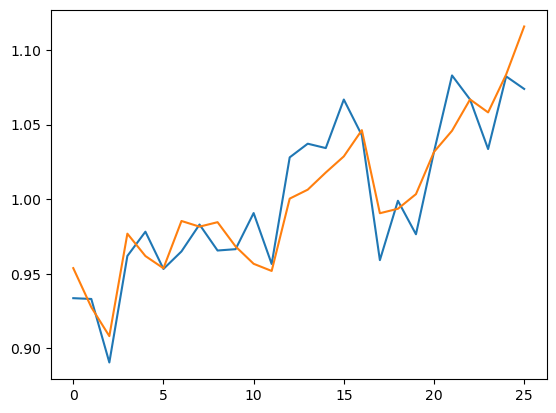

In [163]:
plt.plot(np.arange(len(Bh)),Bh[:,2])
plt.plot(np.arange(len(Bh)),Bv[:,2])

In [164]:
Bhp = model(PBv_coords)
Bhp

tensor([[-0.0413, -0.0011,  0.9382],
        [-0.0371,  0.0058,  0.9402],
        [-0.0325,  0.0124,  0.9399],
        ...,
        [ 0.0418, -0.0086,  1.0852],
        [ 0.0484, -0.0026,  1.0834],
        [ 0.0546,  0.0032,  1.0796]], grad_fn=<AddmmBackward0>)

In [165]:
torch.autograd.grad(Bhp,PBv_coords,torch.ones_like(Bhp))[0].shape

torch.Size([1305, 3])

### Why we didn't get [batch_size,output_dim,input_dim]?

* Jacobian matrix find the gradients and it is normally has shape of [output_dim,input_dim]
* But when we called **torch.autograd.grad** we get [batch_size,input_dim], this is because the grad function average the gradeints along the "output dim"

* To get the full Jacobian matrix we can use **torch.autograd.functional.jacobian()**, this returns [batch_size,output_dim,batch_size,input_dim]

In [166]:
#using torch.autograd.functional.jacobian
B_jacob = torch.autograd.functional.jacobian(lambda t:model(t),PBv_coords) # (batch_size, output_dim, batch_size, input_dim)
#the off-diagonal elements of 0th and 2nd dimension are all zero. So we remove them
B_grad  = torch.diagonal(B_jacob,offset=0,dim1=0,dim2=2)                   # (output_dim, input_dim, batch_size)
B_grad  = B_grad.permute(2,0,1)                                            # (batch_size, output_dim, input_dim)    

In [177]:
B_grad

tensor([[[ 7.4248e-03, -1.2660e-02,  2.0391e-02],
         [-1.3365e-04, -1.9863e-02,  3.4928e-02],
         [ 6.4957e-02,  3.5294e-02,  1.6318e-02]],

        [[ 7.5842e-03, -1.1356e-02,  2.1860e-02],
         [-3.5156e-05, -1.8732e-02,  3.3767e-02],
         [ 6.9404e-02,  3.9184e-02,  4.1613e-03]],

        [[ 7.9738e-03, -9.8804e-03,  2.3743e-02],
         [ 1.4826e-04, -1.7608e-02,  3.2705e-02],
         [ 7.3372e-02,  4.3226e-02, -7.0585e-03]],

        ...,

        [[ 1.5601e-02, -4.3756e-03,  3.4176e-02],
         [-4.4849e-03, -2.7995e-02,  3.1153e-02],
         [-9.7032e-03, -4.0518e-02, -3.7287e-03]],

        [[ 1.2508e-02, -5.9616e-03,  3.1952e-02],
         [-4.5651e-03, -2.7914e-02,  2.9538e-02],
         [-4.0484e-03, -3.9226e-02, -1.3988e-02]],

        [[ 9.5836e-03, -7.4205e-03,  2.9940e-02],
         [-4.6189e-03, -2.7747e-02,  2.8057e-02],
         [ 1.4618e-03, -3.7515e-02, -2.3773e-02]]])

In [185]:
# implement del.B = 0 
del_dot_B = torch.diagonal(B_grad,offset=0,dim1=1,dim2=2).sum(dim=1)

In [188]:
# implement del.cross.B 
del_cross_B = B_grad[:,0,1] + B_grad[:,1,0] + B_grad[:,0,2] + B_grad[:,2,0] + B_grad[:,1,2] + B_grad[:,2,1]
del_cross_B

tensor([0.1428, 0.1528, 0.1633,  ..., 0.0062, 0.0077, 0.0099])

In [189]:
del_dot_B.shape

torch.Size([1305])

In [190]:
del_cross_B.shape

torch.Size([1305])